# **Telco Customer Churn**

### One of the biggest challenges in the telecom service industry is to retain customers. Our main aim here is to create a model to forecast if, based on custumer's profile, he or she will churn or not in the future.

### We begin by loading the most relevant packages. After data reading, we discharge the column customer ID, since it will be useless to us.  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
import numpy as np

%matplotlib inline

In [2]:
data = pd.read_csv('./data/data.csv')
data.drop('customerID', axis='columns', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), object(17)
memory usage: 1.1+ MB


### The column TotalCharges was read as strings, because some of the rows the data is non-numerical. We will transform it into numerical data and discharge some few non-numerical rows. We also create a list with the name of the categorical columns.

In [3]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
print(data.shape)
data.dropna(inplace=True)
print(data.shape)

columns = list(data.columns)
columns.remove('MonthlyCharges')
columns.remove('tenure')
columns.remove('TotalCharges')
print(columns)

(7043, 20)
(7032, 20)
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


### We can do some basic exploratory analysis by plotting the categorical features, dividing them in Churn and No Churn. Here we can already make some good assumptions about which kind of customer can churn.

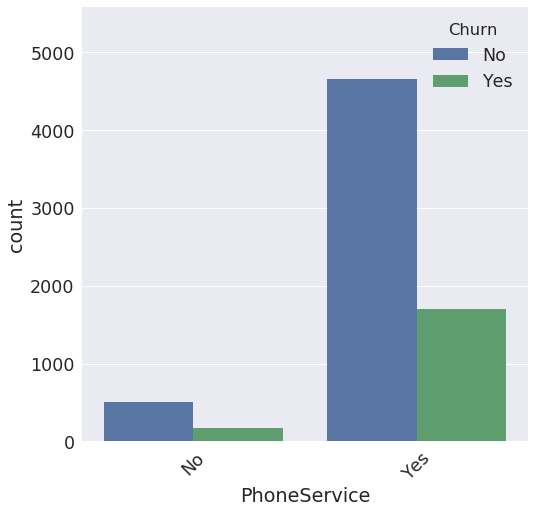

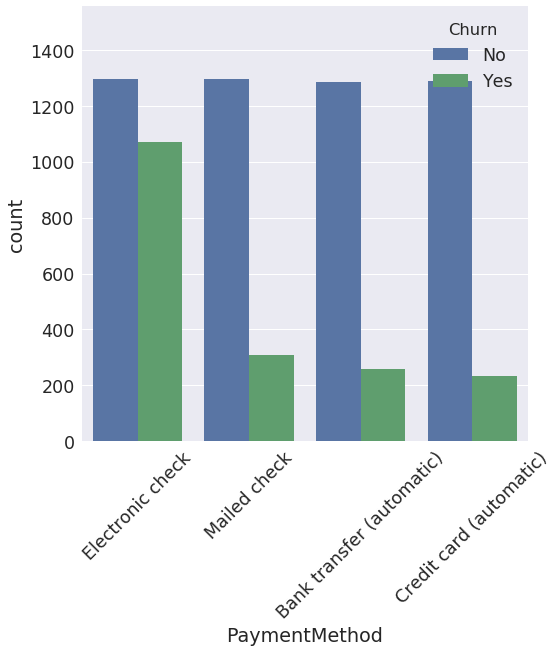

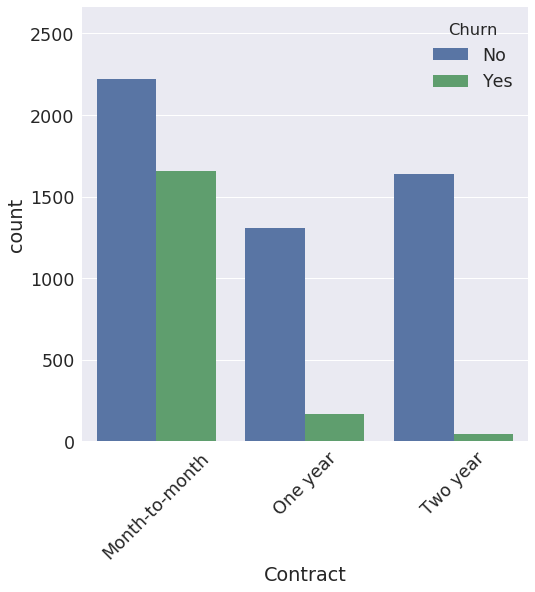

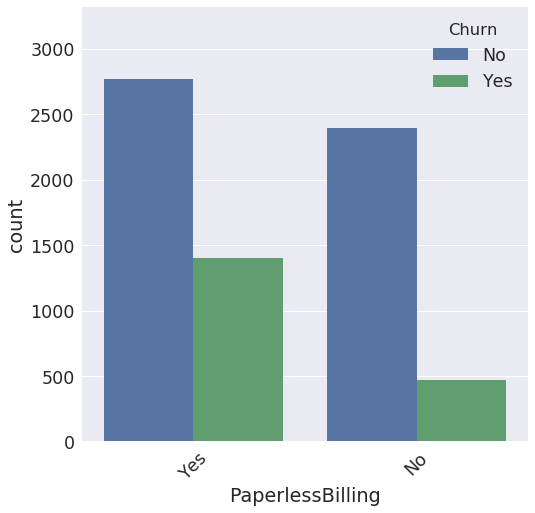

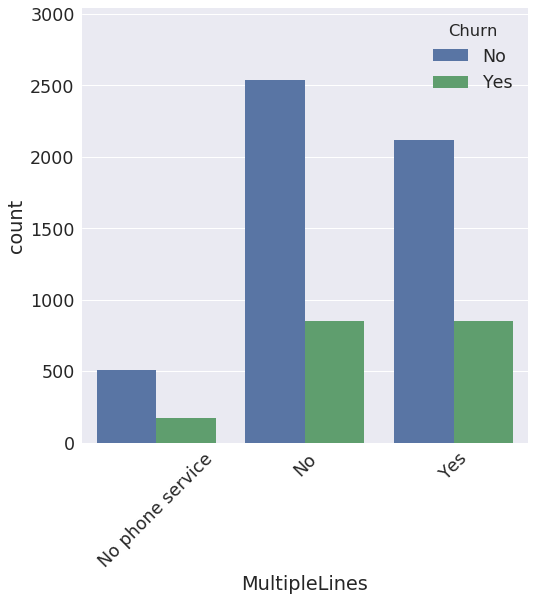

In [4]:
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.75)
for column in sample(columns, 5):
    plt.figure(figsize=(8,8))
    sns.countplot(x=column, hue='Churn', data=data)
    plt.xticks(rotation='45')
    plt.margins(0.2)
    plt.show()
    print('\n\n')

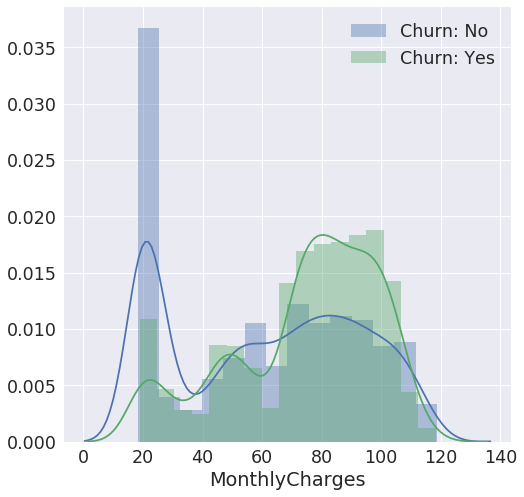

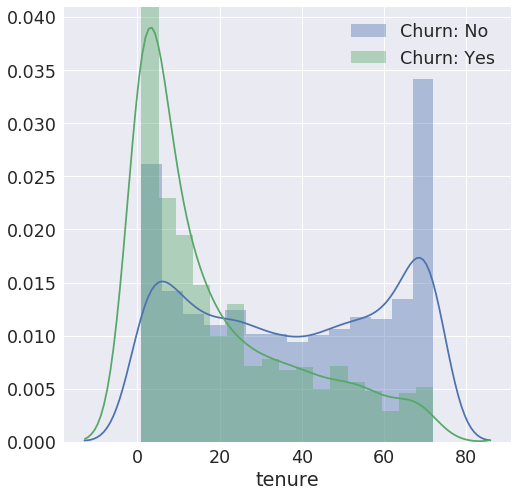

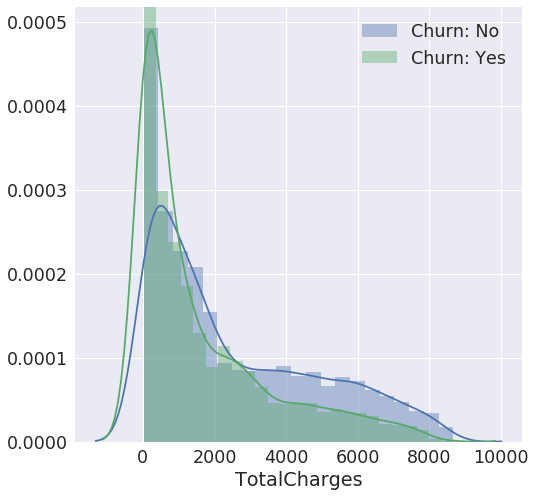

In [5]:
plt.figure(figsize=(8,8))
sns.distplot(data.loc[data['Churn']=='No', 'MonthlyCharges'], label='Churn: No')
sns.distplot(data.loc[data['Churn']=='Yes', 'MonthlyCharges'], label='Churn: Yes')
plt.legend()
plt.show()

plt.figure(figsize=(8,8))
sns.distplot(data.loc[data['Churn']=='No', 'tenure'], label='Churn: No')
sns.distplot(data.loc[data['Churn']=='Yes', 'tenure'], label='Churn: Yes')
plt.legend()
plt.show()

plt.figure(figsize=(8,8))
sns.distplot(data.loc[data['Churn']=='No', 'TotalCharges'], label='Churn: No')
sns.distplot(data.loc[data['Churn']=='Yes', 'TotalCharges'], label='Churn: Yes')
plt.legend()
plt.show()

# Classification

### First we load the relevant packages, and create the function that will present us the results of our models tests.

In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split

In [7]:
def full_report(classifier, X_test, y_test, class_labels):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score
    
    print('Best train score (accuracy) {0:.2f}'.format(clf.best_score_))
    print('Best parameters {}\n'.format(clf.best_params_))

    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    
    test_accuracy = accuracy_score(y_test,y_pred)
    test_f1_score = f1_score(y_test, y_pred)
    test_roc_auc = roc_auc_score(y_test, y_proba)
    
    print('Test Accuracy: {0:.2f}'.format(test_accuracy))
    print('Test f1 score: {0:.2f}'.format(test_f1_score))
    print('Test ROC-AUC: {0:.2f}\n'.format(test_roc_auc))

    print(classification_report(y_test,y_pred, target_names=['No', 'Yes']))

    cnf_matrix = confusion_matrix(y_test, y_pred)
    
    sns.set(style="darkgrid")
    sns.set_context("notebook", font_scale=1.75)
    
    """
    plt.figure(figsize=(8,8))
    plt.title('Confusion matrix')
    sns.heatmap(cnf_matrix, 
                annot=True,
                fmt='d',
                cmap='RdYlBu',
                xticklabels=['No', 'Yes'], 
                yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted')
    plt.ylabel('Observed')
    plt.tight_layout()
    plt.show()
    """
    
    cnf_matrix = 100*(cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis])

    plt.figure(figsize=(8,8))
    plt.title('Confusion matrix (%)')
    sns.heatmap(cnf_matrix, 
                annot=True,
                cmap='RdYlBu',
                xticklabels=['No', 'Yes'], 
                yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted')
    plt.ylabel('Observed')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC Curve (area = %0.2f)' % roc_auc_score(y_test, y_proba))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    
    return [test_accuracy, test_f1_score, test_roc_auc]

def FeaturesImportance(importances, labels):
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    labels = labels[importances > 0]
    importances = importances[importances > 0]
    
    importances = list(importances)
    labels = list(labels)
    
    ordered_labels =[]
    ordered_importances = []
    
    for _ in range(len(importances)):
        i_max = importances.index(max(importances))
        ordered_labels.append(labels[i_max])
        ordered_importances.append(importances[i_max])
        importances.pop(i_max)
        labels.pop(i_max)

    plt.figure(figsize=(8,8))
    plt.title('Features Importance')
    sns.barplot(x=ordered_importances, y=ordered_labels)
    plt.xlabel('Relative importance')
    plt.ylabel('Feature')
    #plt.tight_layout()
    plt.show()

### The categorical data will be encoded into numbers.

In [8]:
X = data[columns[:-1]]

le = LabelEncoder()
y = le.fit_transform(data['Churn'])

dummie_columns = []
for column in columns[:-1]:
    if (len(np.unique(data[column]))==2):
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column])
    else:
        dummie_columns.append(column)

print('Dummie columns: {}'.format(dummie_columns))

X = pd.get_dummies(X, columns=dummie_columns)

X['MonthlyCharges'] = data['MonthlyCharges']
X['tenure'] = data['tenure']
X['TotalCharges'] = data['TotalCharges']
X[['MonthlyCharges', 'tenure', 'TotalCharges']] = StandardScaler().fit_transform(data[['MonthlyCharges', 'tenure', 'TotalCharges']])

X.shape

/home/rodolfo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


Dummie columns: ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


(7032, 40)

### And divided into train and test sets.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [10]:
summary = {}

### Next, we will train our models and look for the best hyper-parameters of each one and test the best model found. In the end, we will present a summary of all results. For the test, we will use as metrics the accuracy, the f1 score, the ROC area under the curve and the confusion matrix, because you know, picture is worth a thousand words.

### The algorithms used here are: Logistic Regression, Support Vector, Stochastic Gradient Descent, Nearest Neighbors, Gaussian Naive Bayes, Bernoulli Naive Bayes Decision Tree, Random Forest, Extra Trees and finally Gradient Boosting.

## **Logistic Regression**

In [11]:
from sklearn.linear_model import LogisticRegression

params = {
    'penalty':['l1','l2'],
    'tol':[1e-6,1e-5,1e-4,1e-3,1e-2],
    'C':[10,1,0.1,0.01,0.001],  
}

log_reg = LogisticRegression(class_weight='balanced',
                            random_state=42)

clf = GridSearchCV(log_reg, param_grid=params, 
                   cv=5, scoring='accuracy', 
                   verbose=1, n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   17.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'tol': [1e-06, 1e-05, 0.0001, 0.001, 0.01], 'C': [10, 1, 0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

Best train score (accuracy) 0.75
Best parameters {'C': 0.1, 'penalty': 'l2', 'tol': 1e-06}

Test Accuracy: 0.73
Test f1 score: 0.61
Test ROC-AUC: 0.83

             precision    recall  f1-score   support

         No       0.90      0.71      0.79       771
        Yes       0.50      0.79      0.61       284

avg / total       0.79      0.73      0.75      1055



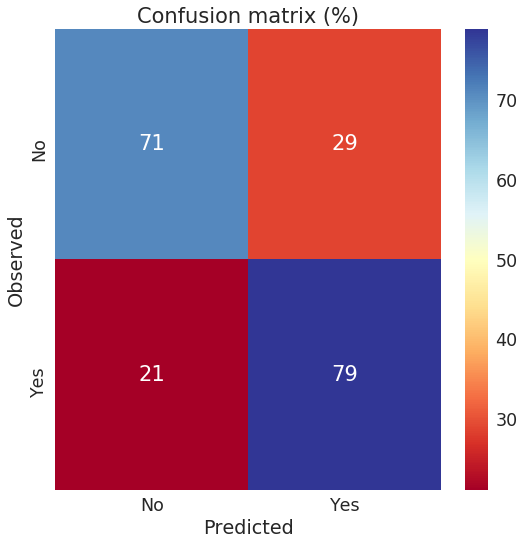

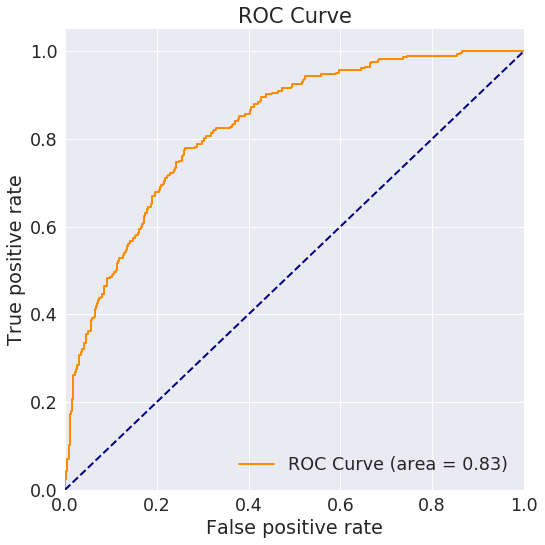

In [12]:
summary['LogisticRegression'] = full_report(clf, X_test, y_test, ['No', 'Yes'])

## **Support Vector Classification**

In [13]:
from sklearn.svm import SVC

params = {
    #'C':[10,1,0.1,0.01,0.001],
    'kernel':['linear', 'rbf', 'poly'],#, 'sigmoid', 'precomputed'],
    'degree':[2,3],
    #'gamma': ['auto', 0.001, 0.01, 0.1], #rbf, poly and sigmoid kernels only
    'tol':[1e-7,1e-6,1e-5],
    #'tol':[1e-6,1e-5,1e-4,1e-3,1e-2],
}

svc_clf = SVC(probability=True, 
              class_weight='balanced', 
              verbose=1, random_state=42)

clf = GridSearchCV(svc_clf, param_grid=params, 
                   cv=5, scoring='accuracy', 
                   verbose=1, n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 105.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 263.2min finished


[LibSVM]

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'kernel': ['linear', 'rbf', 'poly'], 'degree': [2, 3], 'tol': [1e-07, 1e-06, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

Best train score (accuracy) 0.75
Best parameters {'degree': 3, 'kernel': 'poly', 'tol': 1e-07}

Test Accuracy: 0.73
Test f1 score: 0.60
Test ROC-AUC: 0.82

             precision    recall  f1-score   support

         No       0.90      0.71      0.79       771
        Yes       0.49      0.78      0.60       284

avg / total       0.79      0.73      0.74      1055



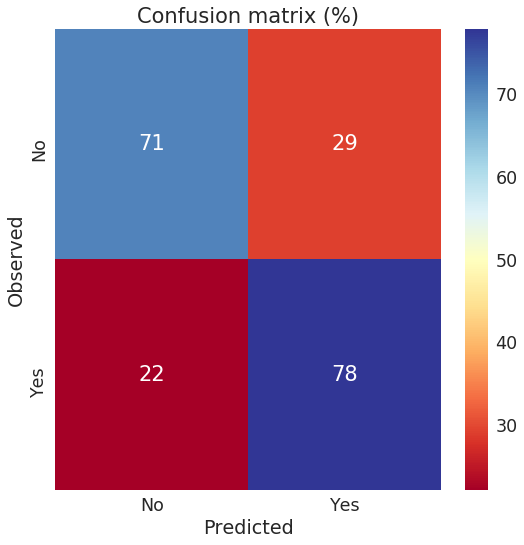

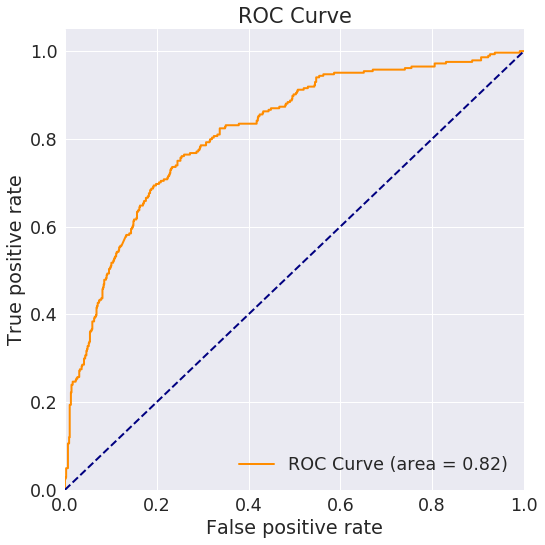

In [14]:
summary['SupportVectorClassification'] = full_report(clf, X_test, y_test, ['No', 'Yes'])

## **Stochastic Gradient Descent**

In [15]:
from sklearn.linear_model import SGDClassifier

#import warnings
#warnings.filterwarnings("once")

params = {
    'loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'alpha':10.0**-np.arange(1,7),
    'tol':10.0**-np.arange(1,5),
    'eta0':10.0**-np.arange(1,5),
    'learning_rate':['constant', 'optimal', 'invscaling'],
}

sgd_clf = SGDClassifier(max_iter=100000, class_weight='balanced', 
              n_jobs=-1, random_state=42)

clf = GridSearchCV(sgd_clf, param_grid=params, 
                   cv=5, scoring='accuracy', 
                   verbose=1, n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 5760 candidates, totalling 28800 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    5.7s
/home/rodolfo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/rodolfo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/rodolfo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/rodolfo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum num

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=100000, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'], 'penalty': [None, 'l2', 'l1', 'elasticnet'], 'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]), 'tol': array([0.1   , 0.01  , 0.001 , 0.0001]), 'eta0': array([0.1   , 0.01  , 0.001 , 0.0001]), 'learning_rate': ['constant', 'optimal', 'invscaling']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

Best train score (accuracy) 0.76
Best parameters {'alpha': 0.001, 'eta0': 0.1, 'learning_rate': 'optimal', 'loss': 'log', 'penalty': None, 'tol': 0.01}

Test Accuracy: 0.75
Test f1 score: 0.62
Test ROC-AUC: 0.82

             precision    recall  f1-score   support

         No       0.89      0.76      0.82       771
        Yes       0.53      0.74      0.62       284

avg / total       0.79      0.75      0.76      1055



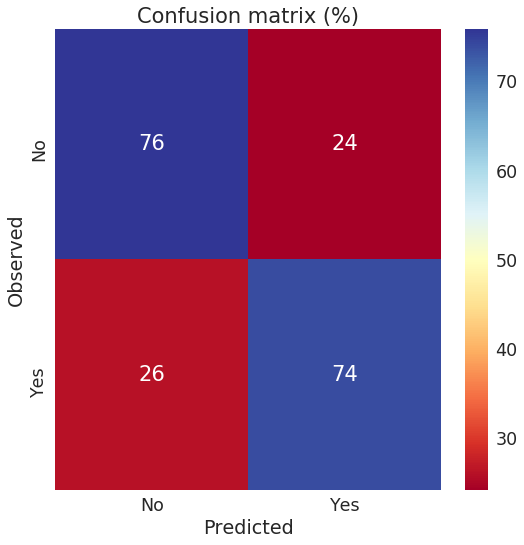

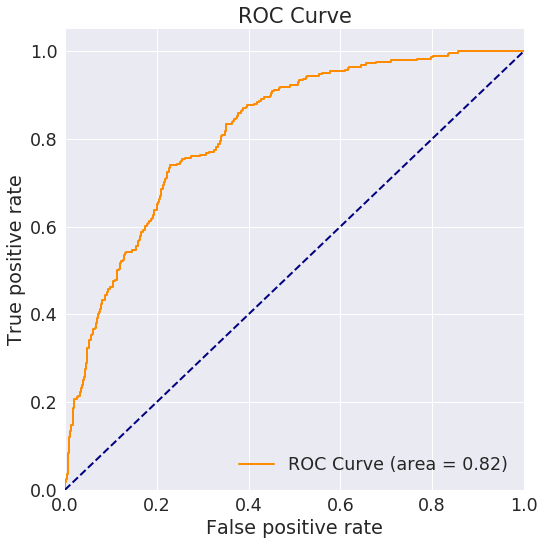

In [16]:
summary['StochasticGradientDescent'] = full_report(clf, X_test, y_test, ['No', 'Yes'])

## **Nearest Neighbors Classification**

In [17]:
from sklearn.neighbors import KNeighborsClassifier

params = {
    'n_neighbors':[10,20,50,70,80,90,100,150,200,250,300,350],
    'weights':['uniform', 'distance'],
    'p':[1,2],
    
}

kn_clf = KNeighborsClassifier(#probability=True,
                              algorithm='auto',
                              n_jobs=-1)

clf = GridSearchCV(kn_clf, param_grid=params, 
                   cv=5, scoring='accuracy', 
                   verbose=1, n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  3.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [10, 20, 50, 70, 80, 90, 100, 150, 200, 250, 300, 350], 'weights': ['uniform', 'distance'], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

Best train score (accuracy) 0.80
Best parameters {'n_neighbors': 90, 'p': 1, 'weights': 'uniform'}

Test Accuracy: 0.78
Test f1 score: 0.58
Test ROC-AUC: 0.82

             precision    recall  f1-score   support

         No       0.84      0.86      0.85       771
        Yes       0.60      0.56      0.58       284

avg / total       0.78      0.78      0.78      1055



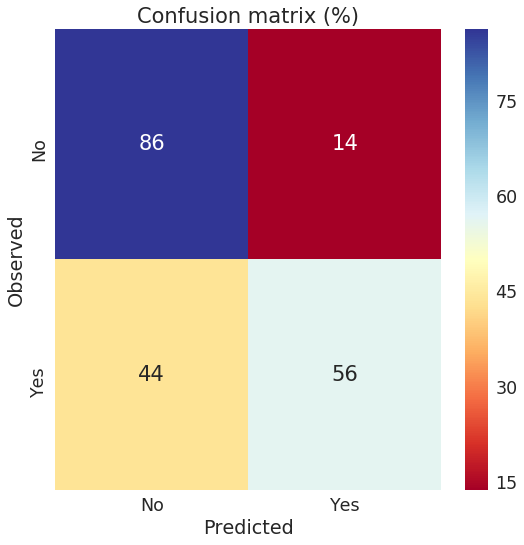

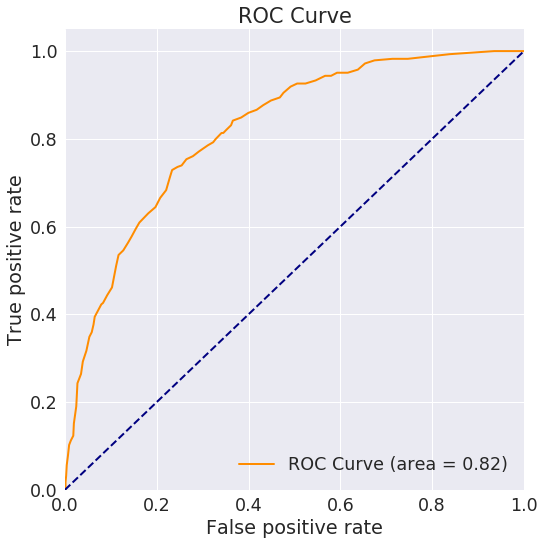

In [18]:
summary['KNeighborsClassifier'] = full_report(clf, X_test, y_test, ['No', 'Yes'])

## **Gaussian Naive Bayes**

In [19]:
from sklearn.naive_bayes import GaussianNB

params = {
}

nb_clf = GaussianNB()

clf = GridSearchCV(nb_clf, param_grid=params, 
                   cv=5, scoring='accuracy', 
                   verbose=1, n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


GridSearchCV(cv=5, error_score='raise', estimator=GaussianNB(priors=None),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

Best train score (accuracy) 0.70
Best parameters {}

Test Accuracy: 0.68
Test f1 score: 0.58
Test ROC-AUC: 0.81

             precision    recall  f1-score   support

         No       0.91      0.62      0.74       771
        Yes       0.45      0.83      0.58       284

avg / total       0.79      0.68      0.70      1055



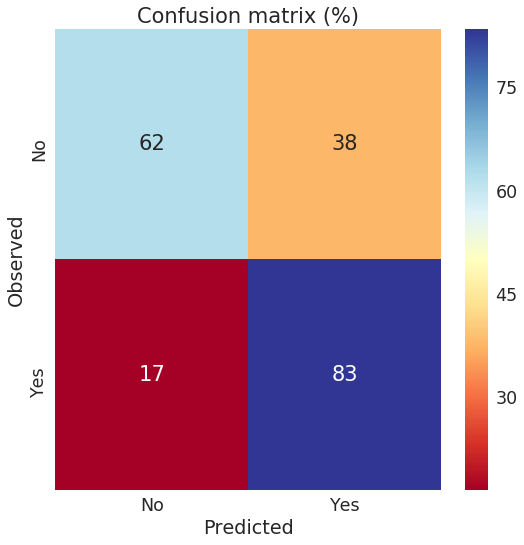

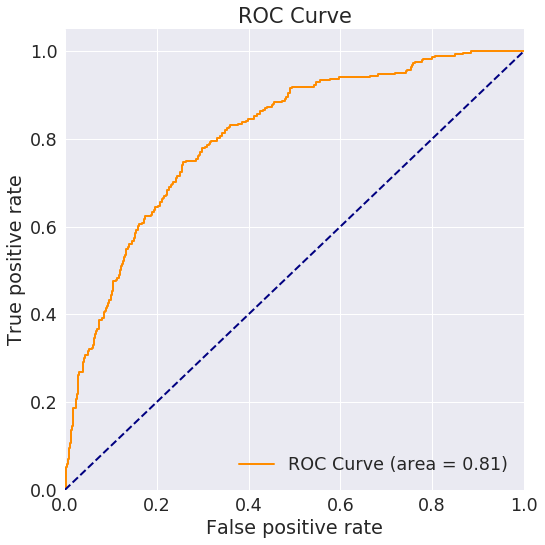

In [20]:
summary['GaussianNaiveBayes'] = full_report(clf, X_test, y_test, ['No', 'Yes'])

## **Bernoulli Naive Bayes**

In [21]:
from sklearn.naive_bayes import BernoulliNB

params = {
    'alpha':10.0**-np.arange(0,5),
}

nb_clf = BernoulliNB()

clf = GridSearchCV(nb_clf, param_grid=params, 
                   cv=5, scoring='accuracy', 
                   verbose=1, n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

Best train score (accuracy) 0.73
Best parameters {'alpha': 0.1}

Test Accuracy: 0.71
Test f1 score: 0.60
Test ROC-AUC: 0.81

             precision    recall  f1-score   support

         No       0.90      0.68      0.77       771
        Yes       0.48      0.80      0.60       284

avg / total       0.79      0.71      0.73      1055



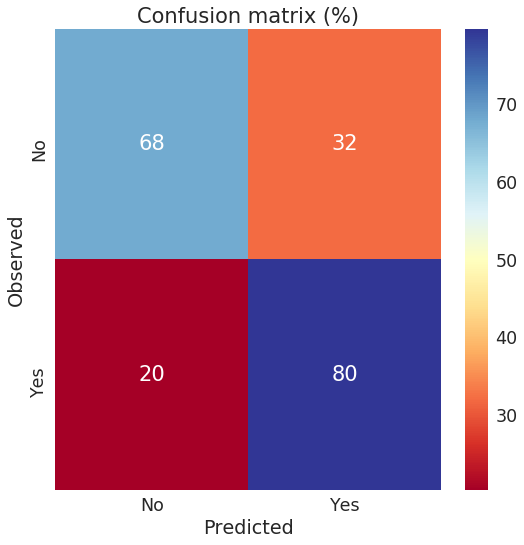

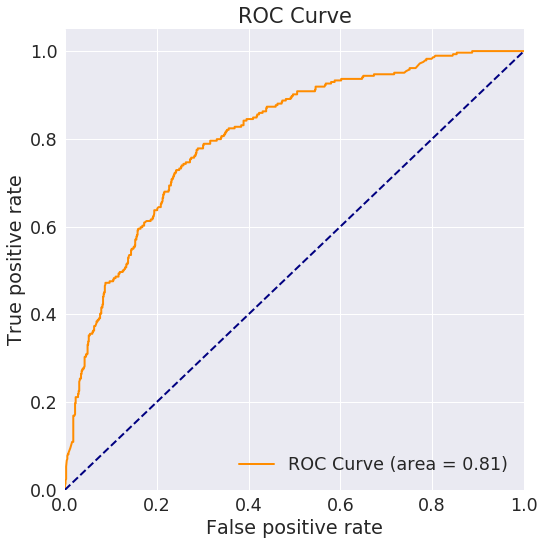

In [22]:
summary['BernoulliNaiveBayes'] = full_report(clf, X_test, y_test, ['No', 'Yes'])

## **Decision Tree Classifier**

In [23]:
from sklearn.tree import DecisionTreeClassifier

params = {
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':list(range(1,11)),
    'min_samples_split':list(range(2,11)),
    'min_samples_leaf':list(range(1,11)),
    'max_features':['auto','sqrt','log2',None],
    
}

dt_clf = DecisionTreeClassifier(random_state=42, class_weight='balanced')

clf = GridSearchCV(dt_clf, param_grid=params, 
                   cv=5, scoring='accuracy', 
                   verbose=1, n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 14400 candidates, totalling 72000 fits


[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2824 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 7024 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 12424 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 19024 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 26824 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 35824 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 46024 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 57424 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 70024 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 72000 out of 72000 | elapsed:  5.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_features': ['auto', 'sqrt', 'log2', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

Best train score (accuracy) 0.76
Best parameters {'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}

Test Accuracy: 0.74
Test f1 score: 0.60
Test ROC-AUC: 0.81

             precision    recall  f1-score   support

         No       0.88      0.76      0.81       771
        Yes       0.52      0.71      0.60       284

avg / total       0.78      0.74      0.75      1055



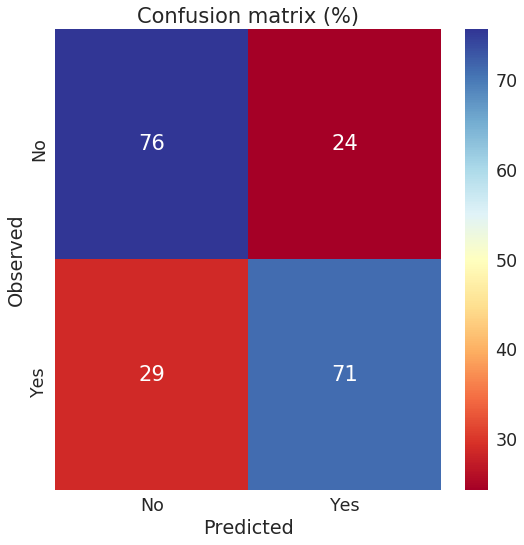

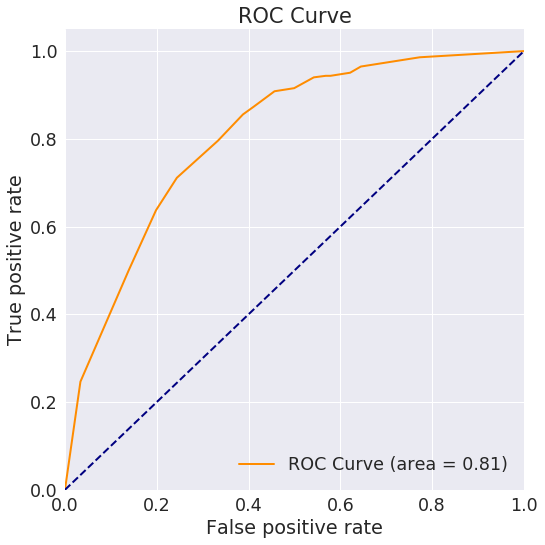

In [24]:
summary['DecisionTreeClassifier'] = full_report(clf, X_test, y_test, ['No', 'Yes'])

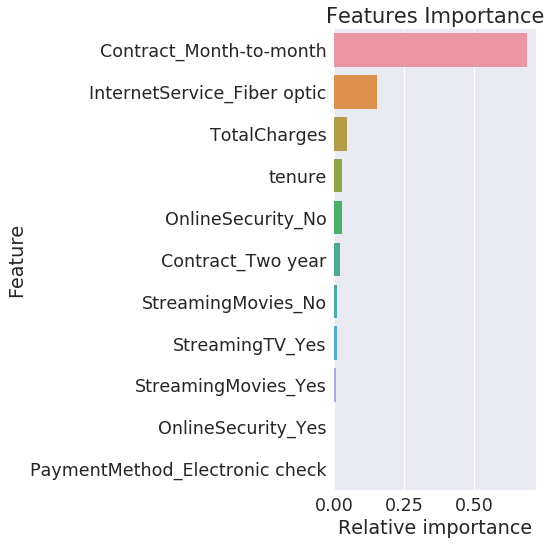

In [25]:
FeaturesImportance(clf.best_estimator_.feature_importances_, X.columns) 

## **Random Forest Classifier**

In [26]:
from sklearn.ensemble import RandomForestClassifier

params = {
    'n_estimators':[10]+list(range(50,301,50)),
    'criterion':['gini','entropy'],
    'max_features':['auto','sqrt','log2',None],
    'max_depth':list(range(1,4)),
    'min_samples_split':list(range(2,5)),
    'min_samples_leaf':list(range(1,4)),
}

rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

clf = GridSearchCV(rf_clf, param_grid=params, 
                   cv=5, scoring='accuracy', 
                   verbose=1, n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 1512 candidates, totalling 7560 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 7560 out of 7560 | elapsed: 34.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 100, 150, 200, 250, 300], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2', None], 'max_depth': [1, 2, 3], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

Best train score (accuracy) 0.74
Best parameters {'criterion': 'entropy', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Test Accuracy: 0.73
Test f1 score: 0.60
Test ROC-AUC: 0.82

             precision    recall  f1-score   support

         No       0.89      0.71      0.79       771
        Yes       0.50      0.76      0.60       284

avg / total       0.78      0.73      0.74      1055



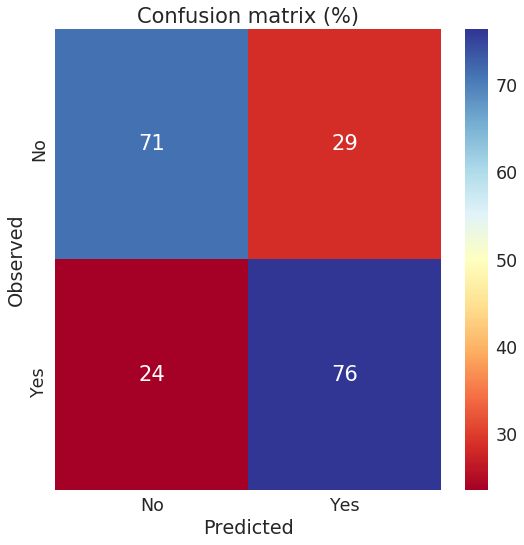

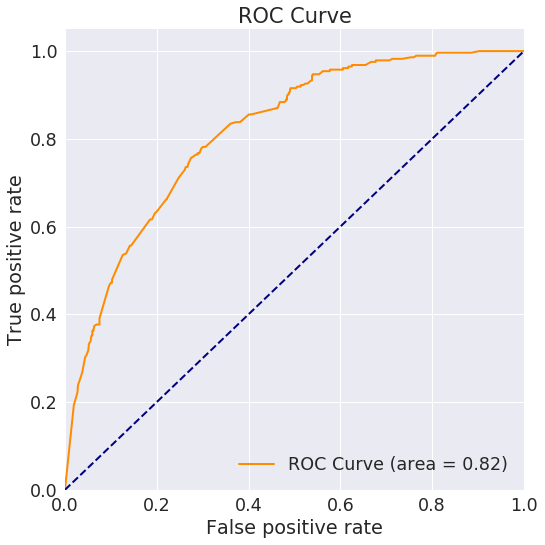

In [27]:
summary['RandomForestClassifier'] = full_report(clf, X_test, y_test, ['No', 'Yes'])

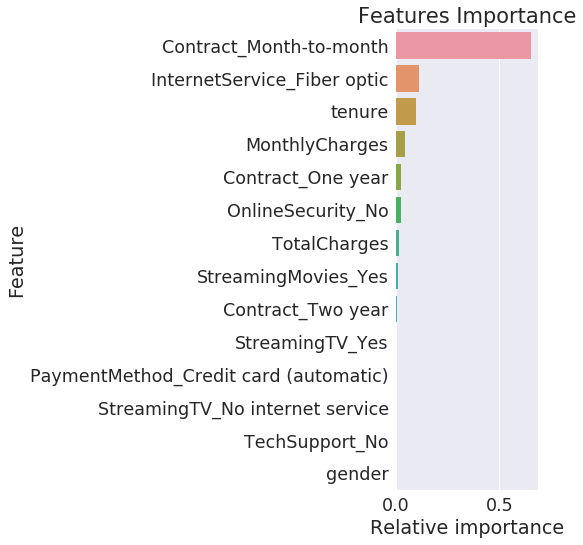

In [28]:
FeaturesImportance(clf.best_estimator_.feature_importances_, X.columns)

## **Extra Trees Classifier**

In [29]:
from sklearn.ensemble import ExtraTreesClassifier

params = {
    'n_estimators':[10]+list(range(50,301,50)),
    'criterion':['gini','entropy'],
    'max_features':['auto','sqrt','log2',None],
    'max_depth':list(range(1,4)),
    'min_samples_split':list(range(2,5)),
    'min_samples_leaf':list(range(1,4)),
}

ext_clf = ExtraTreesClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

clf = GridSearchCV(ext_clf, param_grid=params, 
                   cv=5, scoring='accuracy', 
                   verbose=1, n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 1512 candidates, totalling 7560 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done 7560 out of 7560 | elapsed: 30.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 100, 150, 200, 250, 300], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2', None], 'max_depth': [1, 2, 3], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

Best train score (accuracy) 0.73
Best parameters {'criterion': 'entropy', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}

Test Accuracy: 0.72
Test f1 score: 0.61
Test ROC-AUC: 0.81

             precision    recall  f1-score   support

         No       0.90      0.70      0.79       771
        Yes       0.49      0.79      0.61       284

avg / total       0.79      0.72      0.74      1055



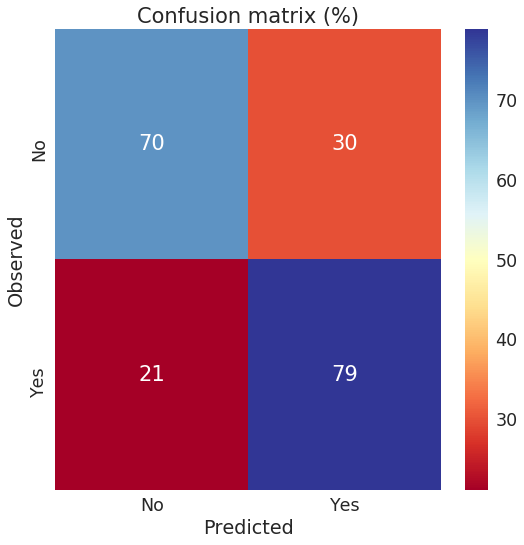

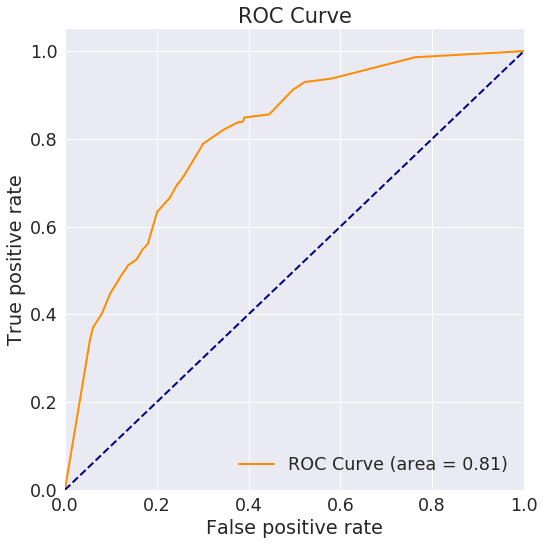

In [30]:
summary['ExtraTreesClassifier'] = full_report(clf, X_test, y_test, ['No', 'Yes'])

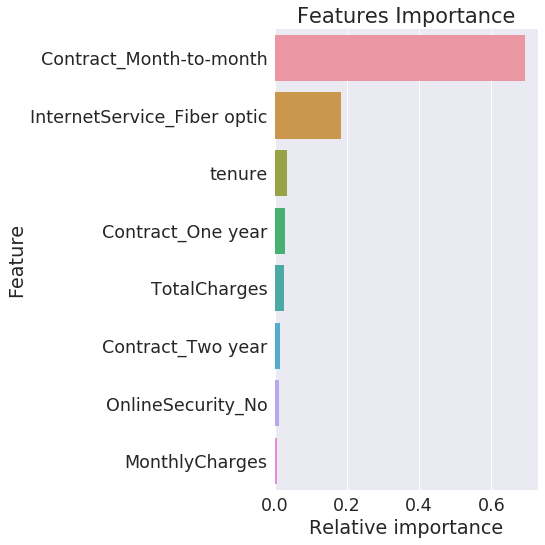

In [31]:
FeaturesImportance(clf.best_estimator_.feature_importances_, X.columns)

## **Gradient Boosting Classifier**

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

params = {
    'n_estimators':list(range(100,401,100)),
    'loss':['deviance', 'exponential'],
    'learning_rate':[0.1,0.01],
    'min_samples_split':list(range(2,11)),
    'subsample':[0.5,1.0],
    'max_features':['auto','sqrt','log2',None],
}

gb_clf = GradientBoostingClassifier(random_state=42)

clf = GridSearchCV(gb_clf, param_grid=params, 
                   cv=5, scoring='accuracy', 
                   verbose=1, n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 41.4min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed: 48.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300, 400], 'loss': ['deviance', 'exponential'], 'learning_rate': [0.1, 0.01], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'subsample': [0.5, 1.0], 'max_features': ['auto', 'sqrt', 'log2', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

Best train score (accuracy) 0.81
Best parameters {'learning_rate': 0.1, 'loss': 'deviance', 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}

Test Accuracy: 0.79
Test f1 score: 0.56
Test ROC-AUC: 0.84

             precision    recall  f1-score   support

         No       0.83      0.91      0.86       771
        Yes       0.66      0.49      0.56       284

avg / total       0.78      0.79      0.78      1055



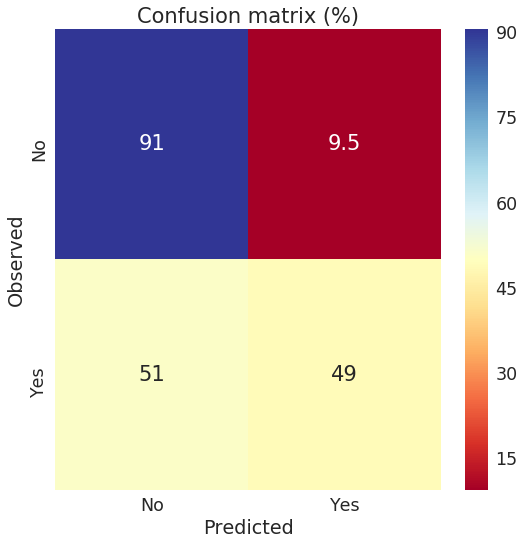

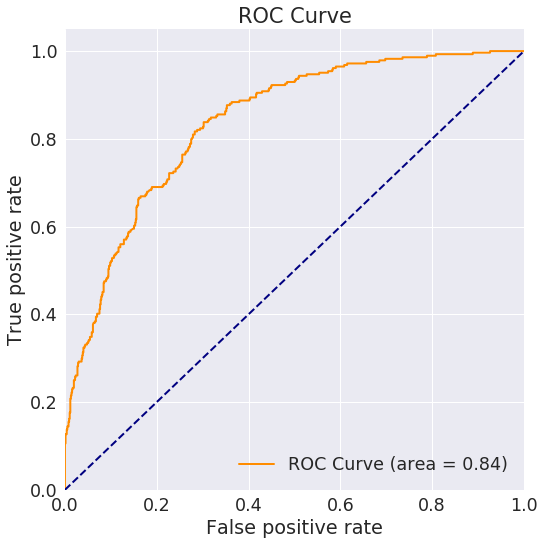

In [33]:
summary['GradientBoostingClassifier'] = full_report(clf, X_test, y_test, ['No', 'Yes'])

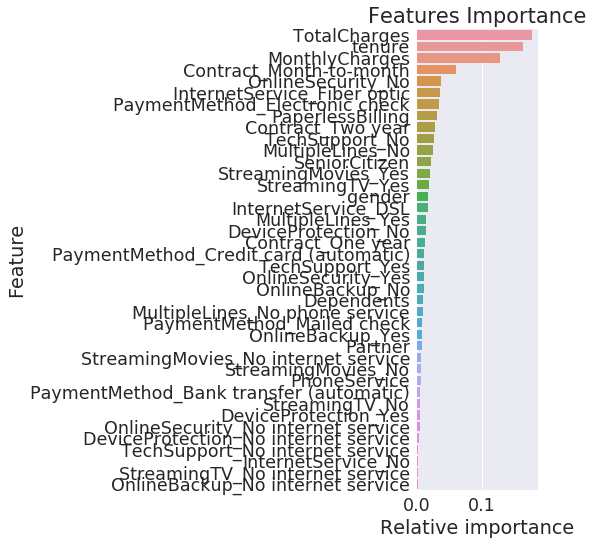

In [34]:
FeaturesImportance(clf.best_estimator_.feature_importances_, X.columns)

In [35]:
summary = pd.DataFrame.from_dict(summary, orient='index')#, columns=['Accuracy', 'f1 score', 'ROC area'])
summary.rename(columns ={0:'Accuracy', 1:'f1 score', 2:'ROC area'}, inplace=True)
print(summary)

                             Accuracy  f1 score  ROC area
LogisticRegression           0.731754  0.612859  0.827186
SupportVectorClassification  0.726066  0.604651  0.817545
StochasticGradientDescent    0.753555  0.617647  0.818774
KNeighborsClassifier         0.781991  0.581818  0.819523
GaussianNaiveBayes           0.678673  0.583026  0.808073
BernoulliNaiveBayes          0.710900  0.597094  0.807039
DecisionTreeClassifier       0.744076  0.599407  0.807434
RandomForestClassifier       0.727014  0.601108  0.815689
ExtraTreesClassifier         0.723223  0.605405  0.805365
GradientBoostingClassifier   0.793365  0.560484  0.837905


# **Conclusion**

### As can be seen, with the present data the models developed here are fairly good. The main problem here, as in many other real cases, is the lack o balance between the classes, which in this case means that there are almost 3 times more samples in the No Churn class.

### Even thought, some simple models, that run faster then others, like logistic regression and decision trees could restore the balance and could maybe be improved with more data. On the other hand, some models were better in one of the classes. One could use each of them depending on the objectives.

### In general, all the models could be improved with a bigger, balanced data set. More features could also be helpful.